In [1]:
import numpy as np
import torch
import torch.nn as nn
import os
import random
import matplotlib
import matplotlib.pyplot as plt
import argparse
import seaborn as sns
import pandas as pd
# %matplotlib notebook
# %matplotlib widget
# !pip install clustpy
import pickle
import random
from IPython.display import clear_output
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [2]:
from tpp import SelfExcitingProcess, SelfCorrectingProcess, plot_1d_pointprocess, concat_array, concat_2d_array
from nn_models import Exponential_Hawkes, generate_initial_weights_and_biases, config_generate, model_train, SimpleLSTM, NeuralHawkes, NHSTPP
from embedding_binning import discretize, select_opt_bin

# Generate Data

In [3]:
base_mu = 1
alpha = 1
beta = 1.25

In [4]:

# se = SelfExcitingProcess(base_mu, alpha, beta, 100, [0., 100.], 1e+2, 800)
# se_time_train, se_lam_train, se_len_train = se.simulate_multiple_seq()
# se_time_test, se_lam_test, se_len_test = se.simulate_multiple_seq()
# sc = SelfCorrectingProcess(2.5, 0.05, 0.25, 100, [0., 100.], 1e+2, 500)
# sc_time_train, sc_lam_train, sc_len_train = \
# sc.simulate_multiple_seq()
# sc_time_test, sc_lam_test, sc_len_test = \
#         sc.simulate_multiple_seq()
# _ = plot_1d_pointprocess(se, se_time_train[19], [0.,100.], 300)
# _ = plot_1d_pointprocess(sc, sc_time_train[15], [0.,100.], 300)

In [5]:
# data_to_save = {
#     'se_time_train': se_time_train,
#     'se_lam_train': se_lam_train,
#     'se_len_train': se_len_train,
#     'se_time_test': se_time_test,
#     'se_lam_test': se_lam_test,
#     'se_len_test': se_len_test,
#     'sc_time_train': sc_time_train,
#     'sc_lam_train': sc_lam_train,
#     'sc_len_train': sc_len_train,
#     'sc_time_test': sc_time_test,
#     'sc_lam_test': sc_lam_test,
#     'sc_len_test': sc_len_test
#     }
# with open('training_data.pkl', 'wb') as file:
#         pickle.dump(data_to_save, file)
# print("Data has been serialized and saved to 'training_data.pkl'")

In [6]:
import pickle

file_name = 'training_data.pkl'
with open(file_name, 'rb') as file:
    data_loaded = pickle.load(file)
print(data_loaded.keys())
for key, value in data_loaded.items():

    globals()[key] = value


dict_keys(['se_time_train', 'se_lam_train', 'se_len_train', 'se_time_test', 'se_lam_test', 'se_len_test', 'sc_time_train', 'sc_lam_train', 'sc_len_train', 'sc_time_test', 'sc_lam_test', 'sc_len_test'])


In [7]:
# this example contains 100 seqeunces for each se and sc model
total_train = [se_time_train, se_time_test,
               sc_time_train, sc_time_test]
total_train_len = [se_len_train, se_len_test,
                   sc_len_train, sc_len_test]
total_train_lam = [se_lam_train, sc_lam_train]
train = concat_array(total_train, total_train_len, [50, 50, 50, 50])

## Real Data

### Weather Data

In [8]:
pitts = pd.read_csv('Real Data/pitts_1991_after.csv')
sfo = pd.read_csv('Real Data/sfo_1991_after.csv')
pitts = pitts[pitts['TAVG'].notna()] 
sfo = sfo[sfo['TAVG'].notna()] 
def weather_process(pitts):
    pitts['date'] = pd.to_datetime(pitts['DATE'])
    pitts['year'] = pitts['date'].dt.year
    valid_pitts = pitts.groupby('year').size()[pitts.groupby('year').size() > 360].index
    pitts = pitts[pitts['year'].isin(valid_pitts)]
    pitts['time'] = pitts['date'].dt.dayofyear
    pitts = pitts.loc[:,['year', 'time', 'TAVG']]

    grouped = pitts.groupby('year')
    pitts_list = []
    for name, group in grouped:
        group = group.sort_values('time')
        np_array = group[['time', 'TAVG']].to_numpy()
        pitts_list.append(np_array)
    return(pitts_list)
pitts_list = weather_process(pitts)
sfo_list = weather_process(sfo)

/var/folders/69/r64yfkxd5z1dl3nbs7p5lv7m0000gn/T/ipykernel_52844/2678135693.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitts['time'] = pitts['date'].dt.dayofyear
/var/folders/69/r64yfkxd5z1dl3nbs7p5lv7m0000gn/T/ipykernel_52844/2678135693.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitts['time'] = pitts['date'].dt.dayofyear


### Earthquake

In [9]:
import time
import datetime
japan = pd.read_csv("Real Data/Japan.csv")
japan = japan[japan['magnitude'] >= 3]

japan_tsp = japan
def get_tsp(df, time_string, methods, offset, lat_name, lon_name):
    def get_raw_seconds(string, offset):
        dt = datetime.datetime.strptime(string, methods)
        epoch = datetime.datetime(offset[0], offset[1], offset[2])
        timestamp = (dt - epoch).total_seconds()
        return timestamp
    df['raw_seconds'] = df[time_string].apply(
        get_raw_seconds, offset = offset)

    df['raw_seconds'] = (df['raw_seconds'] - 
                                df['raw_seconds'].min())/\
                                    (df['raw_seconds'].max() - 
                                    df['raw_seconds'].min()) * 30
    # (japan_tsp.to_csv('japan_seconds.csv'))
    df[lat_name] = (df[lat_name] - df[lat_name].min())/\
        (df[lat_name].max() - df[lat_name].min())
    df[lon_name] = (df[lon_name] - df[lon_name].min())/\
        (df[lon_name].max() - df[lon_name].min())
    df = df[['raw_seconds', lat_name, lon_name]]
    return df
japan_temp = get_tsp(japan_tsp, 'origin_time', "%Y-%m-%d %H:%M:%S.%f", (1990, 1, 1),
                    'Lat', 'Lon')
japan_temp

,raw_seconds,Lat,Lon
0,4.093046,0.560558,0.798456
1,4.093361,0.568543,0.795805
2,4.093694,0.023322,0.080551
3,4.094086,0.564133,0.798653
4,4.097371,0.565921,0.794626
...,...,...,...
31776,29.997963,0.418694,0.680645
31777,29.998745,0.579483,0.786514
31778,29.998994,0.425641,0.710147
31779,29.999721,0.546126,0.759291


In [10]:
nc = pd.read_csv('Real Data/dbsearch.txt', delimiter=',')
datetimes = pd.to_datetime(nc['DateTime'], format="%Y/%m/%d %H:%M:%S.%f")
min_datetime_row = nc['DateTime'].loc[datetimes.idxmin()]
print(datetime.datetime.strptime(min_datetime_row, "%Y/%m/%d %H:%M:%S.%f"))
nc_temp = get_tsp(nc, 'DateTime', "%Y/%m/%d %H:%M:%S.%f", (1993, 1, 1),
                    'Latitude', 'Longitude')
nc_temp

1993-01-01 17:42:47.970000


,raw_seconds,Latitude,Longitude
0,0.000000,0.675974,0.179185
1,0.003755,0.571835,0.312686
2,0.009886,0.236293,0.666566
3,0.017735,0.266399,0.676350
4,0.023560,0.641305,0.297158
...,...,...,...
7145,29.971115,0.381449,0.445736
7146,29.972697,0.381316,0.445837
7147,29.973315,0.195964,0.641859
7148,29.985751,0.587842,0.501289


In [11]:
train_temp = concat_array([np.array([nc_temp['raw_seconds']]), np.array([japan_temp['raw_seconds']])],
                          [np.array([len(list(nc_temp['raw_seconds']))]),np.array([len(list(japan_temp['raw_seconds']))])],
                          [1,1])
train_temp.shape

(2, 31781)

In [12]:
train_all = concat_2d_array([np.array([nc_temp]), np.array([japan_temp])],
                          [np.array([len(list(nc_temp['raw_seconds']))]),np.array([len(list(japan_temp['raw_seconds']))])],
                          [1,1])
train_all.shape

(2, 31781, 3)

# Learn Neural Network

In [101]:
T = [0, 100]
nsample = 10
n_class = 1
n_cluster = 1
int_res = 200
hid_dim = 3
batch_size = 1
lr = 0.00025
momentum = 0.6
epoch = 150
ngrid = 100
weight_decay = 1e-4
max_bin = 20
lam_reg = 0.05
config = config_generate(T0=str(T[0]),
                        T1=str(T[1]),
                        int_res=str(int_res),
                        n_class=str(n_class),
                        lr=str(lr),
                        momentum = str(momentum),
                        epoch=str(epoch),
                        hid_dim=str(hid_dim),
                        batch_size=str(batch_size),
                        opt = "SGD",
                        base_mu = str(base_mu), alpha=str(alpha), beta=str(beta),
                        weight_decay = str(weight_decay),
                        max_bin = str(max_bin),
                        lam_reg = str(lam_reg))

Training on cpu


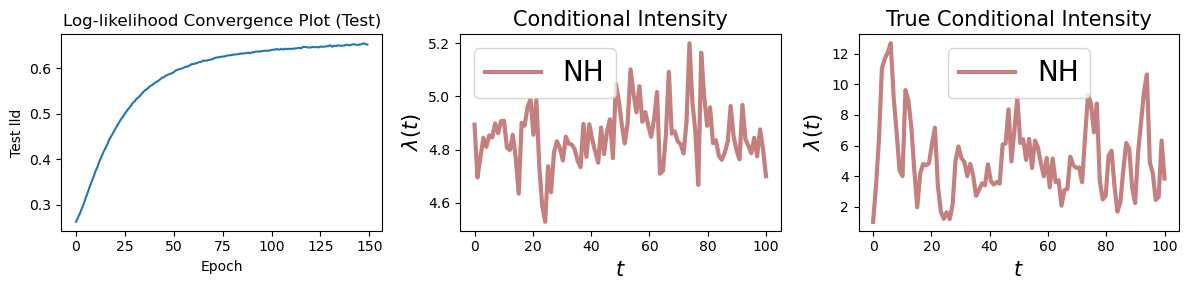

training done!


In [115]:
# define real observations and the one generated from models
idx = [28, 56]
idx0, idx1 = idx[0], idx[1]
train_llks = np.array([np.nan])
while np.isnan(train_llks[-1]):
    train_time = train[idx0]
    nh_model = NeuralHawkes(config)
    nh_model, train_llks, test_llks, test_maes= \
        model_train(train_time.reshape((1,-1)), train_time.reshape((1,-1)),
                    nh_model, config, False, None, None, True)

# Embedding Binning

## chi square test
$\sum_{i,j}\frac{f_{i} g_{i}}{f_{ij} + g_{ij}} \left(\frac{f_{ij}}{f_{i}} - \frac{g_{ij}}{g_{i}}\right)^2$


In [16]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
def chi_square_test(f, g, verbose = False):
    epsilon = 1e-20
    f = f
    g = g
    f_i = np.sum(f, axis=1, keepdims=True)
    # print(f_i)
    g_i = np.sum(g, axis=1, keepdims=True)
    # print(g_i)
    f_ij_i = np.nan_to_num(f / f_i)
    g_ij_i = np.nan_to_num(g / g_i)
    common_p = np.nan_to_num((f + g) / (f_i + g_i))
    fg_i = np.nan_to_num((f_i * g_i) / (f + g))

    # print(fg_i)
    # chi_square_stat = np.sum((f - f_i * common_p)**2/(f_i * common_p)+\
    #     (g - g_i * common_p)**2/(g_i * common_p))
    chi_square_stat = np.sum(np.nan_to_num((f - f_i * common_p)**2 / (f_i * common_p)) +
                             np.nan_to_num((g - g_i * common_p)**2 / (g_i * common_p)))
    # print(f_i * common_p)
    # chi_mat = fg_i * (f_ij_i - g_ij_i)**2
    # chi_square_stat = np.sum(chi_mat)
    # print(fg_i, (f_ij_i - g_ij_i)**2)
    s = f.shape[0]
    # print(chi_mat)
    p_value = chi2.sf(chi_square_stat, s*(s-1))
    if verbose: 
        print(chi_square_stat, chi2.ppf(1-0.05,s*(s-1)))
        print("p-value:", p_value)
    return chi_square_stat, p_value

## Process Binning

In [63]:
def run_with_retry(func, real_h, sim_h, lam_reg, zeros, min_state, config, retries=100, delay=0.1):
    import time
    for i in range(retries):
        try:
            p_val = func(real_h, sim_h, lam_reg, zeros, min_state, config)
            return p_val  # If it succeeds, break out of the loop
        except Exception as e:
            print(f"Error: {e}, retrying {i + 1}/{retries}...")
            time.sleep(delay)
            if i == retries - 1:
                raise  # Re-raise the exception after the last retry
        

In [65]:
def process_data(real_h, sim_h, lam_reg, zeros, min_state, config): 
    try:
        H_range = np.concatenate((real_h[0,:,:], sim_h[0,:,:]), axis=0)
        lower, upper = 2.5, 97.5
        lower_bound = np.percentile(H_range, lower, axis=0)
        upper_bound = np.percentile(H_range, upper, axis=0)
        lower_bound_tensor = torch.tensor(lower_bound)
        upper_bound_tensor = torch.tensor(upper_bound)

        mask = (real_h[0, :, :] >= lower_bound_tensor) & (real_h[0, :, :] <= upper_bound_tensor)
        h = real_h[:, :, :][:, mask.all(dim=1)]
        h1 = sim_h[:, :, :][:, ((sim_h[0, :, :] >= lower_bound_tensor) & \
            (sim_h[0, :, :] <= upper_bound_tensor)).all(dim=1)]

        max_dict, max_norm = select_opt_bin(h[0], h1[0], range(1, config.max_bin, 1),
                                            threshold=0, lam_reg=lam_reg,
                                            tolerance=0, 
                                            lower=0,
                                            upper=100, zero= zeros,
                                            min_state=min_state, max_state=50,
                                            verbose=False)
        
        f, p1, g, p2 = discretize((h[0]), (h1[0]), max_norm,
                                  lower=0, upper=100, plot=True)

        # print(f'Select {max_norm} bins out of {max_dict}')
        _, p_val = chi_square_test(f + (1e-20), g + (1e-20), False)
        # return p_val
    except Exception as e:
        print(f"An error occurred: {e}")
        raise
    return p_val

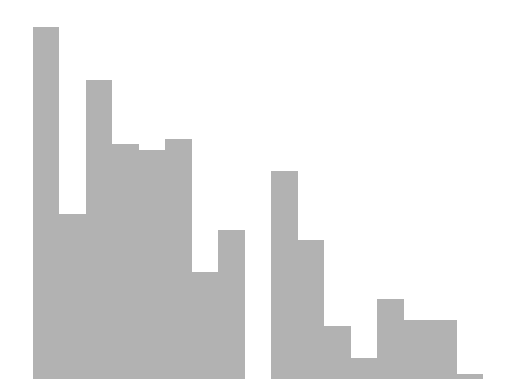

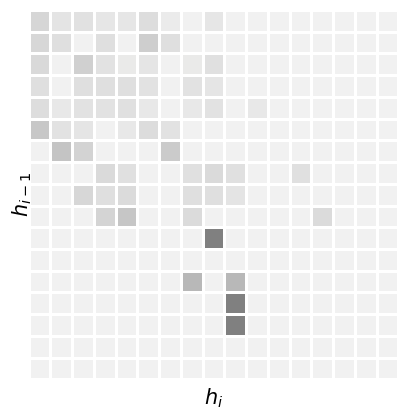

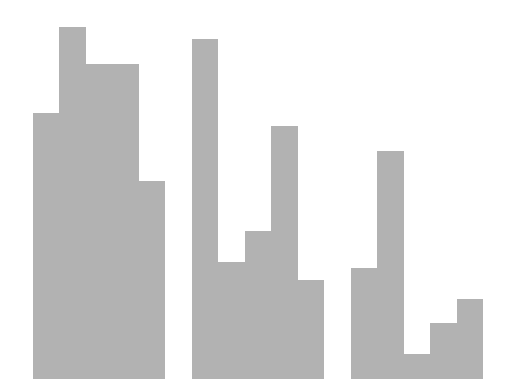

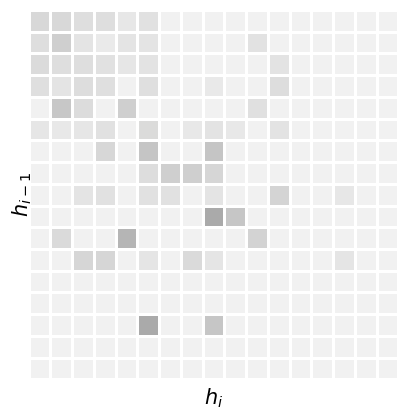

0.12565281631373318


In [117]:
real_h = nh_model.get_H_mat(train[idx0,:].reshape(1,-1), False)
real_h = real_h[:, train[idx0,:] > 0]
real_h_min = np.min(real_h.numpy(), axis=1, keepdims=True)
real_h_max = np.max(real_h.numpy(), axis=1, keepdims=True)
real_h = (real_h - real_h_min) / (real_h_max - real_h_min)

sim_h = nh_model.get_H_mat(train[idx1,:].reshape(1,-1), False)
sim_h = sim_h[:, train[idx1,:] > 0]
sim_h_min = np.min(sim_h.numpy(), axis=1, keepdims=True)
sim_h_max = np.max(sim_h.numpy(), axis=1, keepdims=True)
sim_h = (sim_h - sim_h_min) / (sim_h_max - sim_h_min)

p_val = run_with_retry(process_data, real_h, sim_h, 0.01, 0.3, 15, config,
                                       retries=10, delay=0.1)
print(p_val)

# Baseline For Comparison (Stein, KSD, MMD)

## KSD

In [20]:
# import sys
# sys.path.append('/content/drive/Othercomputers/My MacBook Pro/pptest/Experiment')
from linear_time import GaussianSteinTest
from kernelgof import GoodnessOfFitTest, simulatepm
from ksd import KSD
from mmd import MMD
from scipy.spatial.distance import cdist, pdist, squareform
from kernels import mmd_kernel


In [21]:
def part_seq(data, n = 20):
    # block_volume, remainder = divmod(len(data), 10)
    # blocks_null = [data[i:i+block_volume] for i in range(0, block_volume*9,
    #                                                      block_volume)]
    # blocks_null.append(data[block_volume*9:])
    block_volume = int(np.ceil(len(data)/ n))

    # Partition the space into blocks
    blocks = [(data[i*n:i*n+n].reshape(-1,1)) for i in range(block_volume)]
    return (blocks)

### ksd implementation

In [ ]:
# papangelou_fun for se & vh
def papangelou_model_vh(t, X):
        """
        Papangelou conditional intensity function at time t given points X.
        This is different from the conditional intensity (self.intensity).

        Args:
            t: array(dim), a new time point.
            X: array((..., dim)), existing time-points in a sample.
        """
        assert X.shape[1] == 1

        times = X.ravel()   # array
        denom = [vh.intensity(u, X[X<u]) for u in times[times > t]]  # Check
        g_t = vh.trigger(times[times > t] - t)
        log_frac = np.sum(np.log(denom + g_t) - np.log(denom))

        # Integrated intensity term
        log_Lterm = -vh.alpha/vh.beta * (1.-np.exp(-(vh.T[1]-t)*vh.beta))

        # Intensity term
        log_lterm = np.log(vh.intensity(t, X[X<t]))
        # print(log_Lterm)

        return np.exp(log_Lterm + log_lterm + log_frac)

# papangelou_fun for se & vh
def papangelou_model_se(t, X):
        """
        Papangelou conditional intensity function at time t given points X.
        This is different from the conditional intensity (self.intensity).

        Args:
            t: array(dim), a new time point.
            X: array((..., dim)), existing time-points in a sample.
        """
        assert X.shape[1] == 1

        times = X.ravel()   # array
        denom = [se.intensity(u, X[X<u]) for u in times[times > t]]  # Check
        g_t = se.trigger(times[times > t] - t)
        log_frac = np.sum(np.log(denom + g_t) - np.log(denom))

        # Integrated intensity term
        log_Lterm = -se.alpha/se.beta * (1.-np.exp(-(se.T[1]-t)*vh.beta))

        # Intensity term
        log_lterm = np.log(se.intensity(t, X[X<t]))
        # print(log_Lterm)

        return np.exp(log_Lterm + log_lterm + log_frac)

In [ ]:
null = se_time_test[0]
null = (null[null>0])
null_b =  part_seq(null, 60)
alter = sc_time_test[40]
alter = (alter[alter>0])
alter_b =  part_seq(alter, 60)

dists = pdist(np.concatenate(null_b).reshape(-1,1), metric="sqeuclidean")
rbf_h = np.median(dists)
rbf_h

In [ ]:
def kernel_fun(X, Y):
    return mmd_kernel(X, Y, rbf_h=rbf_h)

mmd = MMD(kernel_fun=kernel_fun, n_boot=10000)
mmd_stat, mmd_thres, mmd_pval, _ = mmd.perform_test(null_b, alter_b)
mmd_pred = 1 * (mmd_stat > mmd_thres)  # 0 for p, 1 for q
print("mmd_pred =", mmd_pred)

In [ ]:
int_method = 'monte_carlo'
ksd_method = 'direct'
ksd = KSD(dim=1, bounds=[(0,1)],
              papangelou_fun=papangelou_model_se,
              kernel_type="mmd",
              int_method=int_method,
              rbf_h=rbf_h,
              mp_npts=10,
              mc_npts=1000,
              disp=False)

kappa = ksd.compute_kappa(alter_b, method='direct')
ksd_stat = ksd.test_statistic(kappa, True)
ksd_thres, ksd_boot = ksd.bootstrap(kappa)
ksd_pval = ksd.p_value(ksd_stat, ksd_boot)
ksd_pred = 1 * (ksd_stat > ksd_thres)  # 0 for p, 1 for q
print("ksd_pred =", ksd_pred)

## Kernel GOF

In [23]:
model = se
def single_log_grad(t, X):
    dlambda = (sum([-model.alpha * model.beta* np.exp(-model.beta * (t - j)) for j in X[X<t]]))
    denom =(model.intensity(t, X[X<t]))
    # print(dlambda)
    deri_integral = -model.alpha * (np.exp(-model.beta * (model.T[1] - t)) - 1)
    res = deri_integral + dlambda/denom
    if type(res) == np.ndarray:
        res = res[0]
    return res
def log_grad(x):
    return [single_log_grad(t,x) for t in x]

# single_log_grad(null[0][130], null[0])

In [ ]:
qm = GoodnessOfFitTest(log_grad)
tester = qm.tester
samples = sc_time_train[0, sc_time_train[0]>0].reshape(-1,1)
alpha = 0.05
chane_prob = 0.1
num_bootstrapped_stats = 100
dims = samples.shape[1]
boots = 10 * int(dims / alpha)
num_samples = samples.shape[0]
U = np.zeros((num_samples, num_samples))
for dim in range(dims):
  U2, _ = tester.get_statistic_multiple_dim(samples, dim)
  U += U2

N = U.shape[0]
bootsraped_stats = np.zeros(num_bootstrapped_stats)
for proc in range(num_bootstrapped_stats):
  # W = np.sign(orsetinW[:,proc])
  W = simulatepm(N, chane_prob)
  WW = np.outer(W, W)
  st = np.mean(U * WW)
  print(np.sum(U * WW-U))
  bootsraped_stats[proc] = N * st
stat = N * np.mean(U)
# print(U)
# print((U * WW))

In [ ]:
p = tester.compute_pvalues_for_processes(U, chane_prob, boots)


In [ ]:
qm = GoodnessOfFitTest(log_grad)
p_val = qm.is_from_null(0.05, sc_time_train[0, sc_time_train[0]>0].reshape(-1,1),
                        0.1)
p_val

In [ ]:
# # # both se
# to_be_test = concat_array(
#     [se_time_train, se_time_test],
#     [se_len_train, se_len_test], [50, 50])
# iterations = 200
# p_vals = []
# for i in range(iterations):
#     idx = random.sample(range(100), 1)[0]
#     # idx1 = idx[0]
#     # idx2 = idx[1]
#     # null = to_be_test[i]
#     # null = [np.array(n[n>0]).reshape(-1,1) for n in null]
#     alter = to_be_test[idx]
#     alter = np.array(alter[alter>0]).reshape(-1,1)
#     qm = GoodnessOfFitTest(log_grad)
#     p_val = qm.is_from_null(0.05, alter, 0.1)
#     print(f"iteration {i} on {idx}th seqeunce with p_value {p_val}")
#     p_vals.append(p_val)

In [ ]:
# qm = GoodnessOfFitTest(log_grad)
# alter = np.array([1]*1000).reshape(-1,1)
# p_val = qm.is_from_null(0.05, alter, 0.1)
# p_val

In [ ]:
# # vh
# to_be_test = concat_array(
#      [vh_time_train, vh_time_test],
#     [vh_len_train, vh_len_test], [500, 500])
# iterations = 200
# p_vals = []
# for i in range(iterations):
#     idx = random.sample(range(1000), 1)[0]
#     # idx1 = idx[0]
#     # idx2 = idx[1]
#     # null = to_be_test[i]
#     # null = [np.array(n[n>0]).reshape(-1,1) for n in null]
#     alter = to_be_test[idx]
#     alter = np.array(alter[alter>0]).reshape(-1,1)
#     qm = GoodnessOfFitTest(log_grad)
#     p_val = qm.is_from_null(0.05, alter, 0.1)
#     print(f"iteration {i} on {idx}th seqeunce with p_value {p_val}")
#     p_vals.append(p_val)

In [ ]:
# # se and sc
# to_be_test = concat_array(
#      [sc_time_train, sc_time_test],
#     [sc_len_train, sc_len_test], [50, 50])
# iterations = 200
# p_vals = []
# model = se
# for i in range(iterations):
#     idx = random.sample(range(100), 1)[0]
#     # idx1 = idx[0]
#     # idx2 = idx[1]
#     # null = to_be_test[i]
#     # null = [np.array(n[n>0]).reshape(-1,1) for n in null]
#     alter = to_be_test[idx]
#     alter = np.array(alter[alter>0]).reshape(-1,1)
#     qm = GoodnessOfFitTest(log_grad)
#     p_val = qm.is_from_null(0.05, alter, 0.1)
#     print(f"iteration {i} on {idx}th seqeunce with p_value {p_val}")
#     p_vals.append(p_val)

In [ ]:
# ngrid = 100
# ts = np.linspace(buffer_end_time, train_data_.max(), ngrid)
# nh_model = NeuralHawkes(config)
# nh_model, train_llks, test_llks, test_maes= \
#     model_train(train_data_, train_data_,
#                 buffer_train_data_, buffer_train_data_,
#                 nh_model, config, True, ts, None)